Epoch [1/100], Loss: 638.4291
Epoch [2/100], Loss: 20.4265
Epoch [3/100], Loss: 6.0410
Epoch [4/100], Loss: 2.8369
Epoch [5/100], Loss: 1.8696
Epoch [6/100], Loss: 1.6121
Epoch [7/100], Loss: 1.4231
Epoch [8/100], Loss: 1.5400
Epoch [9/100], Loss: 1.4289
Epoch [10/100], Loss: 1.6052
Epoch [11/100], Loss: 1.3271
Epoch [12/100], Loss: 1.4207
Epoch [13/100], Loss: 1.3582
Epoch [14/100], Loss: 1.3726
Epoch [15/100], Loss: 1.4737
Epoch [16/100], Loss: 1.8354
Epoch [17/100], Loss: 1.2906
Epoch [18/100], Loss: 1.4766
Epoch [19/100], Loss: 1.3319
Epoch [20/100], Loss: 1.5123
Epoch [21/100], Loss: 1.4864
Epoch [22/100], Loss: 1.2841
Epoch [23/100], Loss: 1.6903
Epoch [24/100], Loss: 1.4929
Epoch [25/100], Loss: 1.3848
Epoch [26/100], Loss: 1.7453
Epoch [27/100], Loss: 1.8963
Epoch [28/100], Loss: 1.2311
Epoch [29/100], Loss: 1.3008
Epoch [30/100], Loss: 1.4129
Epoch [31/100], Loss: 1.2369
Epoch [32/100], Loss: 1.2690
Epoch [33/100], Loss: 1.4384
Epoch [34/100], Loss: 1.3594
Epoch [35/100], Loss

/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


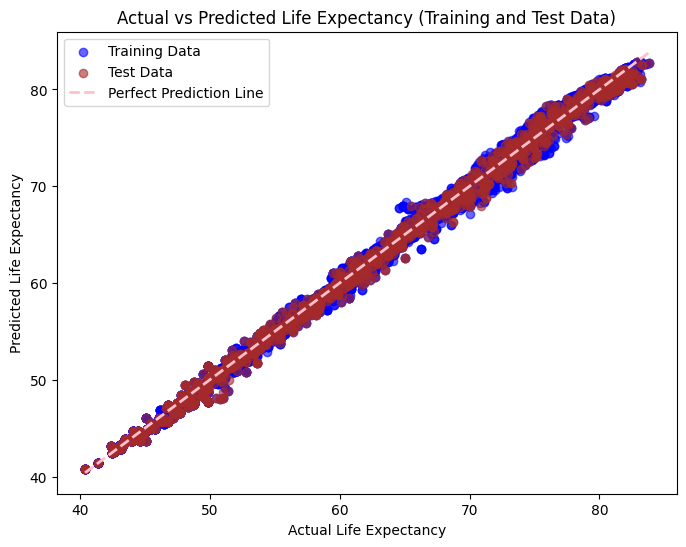

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Load and preprocess data
df = pd.read_csv('../data/data.csv')
df = df.drop(columns=['Country', 'Year', 'Region'])

X = df.drop(columns='Life_expectancy')
y = df['Life_expectancy']

# Bin 'Life_expectancy' and balance data by oversampling smaller bins
df['Life_expectancy_bin'] = pd.cut(y, bins=np.arange(40, 90, 5))
bin_counts = df['Life_expectancy_bin'].value_counts()
max_bin_size = bin_counts.max()
balanced_data = pd.DataFrame()

for life_bin in df['Life_expectancy_bin'].unique():
    bin_data = df[df['Life_expectancy_bin'] == life_bin]
    if len(bin_data) > 0:
        bin_sample = resample(bin_data, replace=True, n_samples=max_bin_size, random_state=1)
        balanced_data = pd.concat([balanced_data, bin_sample])

balanced_data = balanced_data.drop(columns=['Life_expectancy_bin'])
X_balanced = balanced_data.drop(columns='Life_expectancy')
y_balanced = balanced_data['Life_expectancy']

# Split and standardize data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=1)
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define the model
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
batch_size = 32
for epoch in range(num_epochs):
    model.train()
    permutation = torch.randperm(X_train.size()[0])
    epoch_loss = 0

    for i in range(0, X_train.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    average_epoch_loss = epoch_loss / (X_train.size(0) / batch_size)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_epoch_loss:.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f"Test Loss: {test_loss.item():.4f}")

# Prediction on new data
new_data = np.array([[0.5] * X_train.shape[1]])
new_data = scaler.transform(new_data)
new_data = torch.tensor(new_data, dtype=torch.float32)
with torch.no_grad():
    new_prediction = model(new_data)
print("Prediction on new data:", new_prediction.item())

# Plot actual vs predicted
train_predictions = model(X_train).detach().numpy()
test_predictions = model(X_test).detach().numpy()
y_train_np = y_train.numpy()
y_test_np = y_test.numpy()

plt.figure(figsize=(8, 6))
plt.scatter(y_train_np, train_predictions, color='blue', label='Training Data', alpha=0.6)
plt.scatter(y_test_np, test_predictions, color='brown', label='Test Data', alpha=0.6)
plt.plot([y_train_np.min(), y_train_np.max()], [y_train_np.min(), y_train_np.max()], color='pink', linestyle='--', linewidth=2, label='Perfect Prediction Line')
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.legend()
plt.title('Actual vs Predicted Life Expectancy (Training and Test Data)')
plt.show()
